# Preparing the Bathymetry Map for the Lake Mille Lacs Area of Interest

Author: Gregor Beyerle

Date: 2022-06-09

## Overview

This notebook contains the preparation of the bathymetry map for our area of interest: Lake Mille Lacs, a large lake in the U.S. state of Minnesota. I chose this AOI because in addition to being a large inland water body it is also very shallow with a maximum depth of roughly 13 meters. Because it proved to be a rather difficult target for the methods I examine in this project I also added the Bahamas and Puerto Rico AOIs to establish a clear baseline. I sourced the bathymetry map for this lake from [bathybase](http://www.bathybase.org).

In [1]:
import os
import sys
import dotenv

from eolearn.core import (
    FeatureType,
    linearly_connect_tasks,
    EOWorkflow,
    MapFeatureTask,
    RemoveFeatureTask,
    OutputTask,
    SaveTask,
    OverwritePermission
)
from eolearn.core.eoworkflow_tasks import InputTask
from eolearn.io import ImportFromTiffTask, VectorImportTask
from eolearn.geometry import VectorToRasterTask

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import geopandas as gpd

This notebook uses functionality of both the `eolearn_extras` module as well as the `sdb_utils` module. It is important to add the relative location of the repository's root directory to the `sys.path` and import `eolearn_extras` before `sdb_utils` as some functions in this module reference `eolearn_extras`.

In [2]:
root_dir = os.path.abspath('../')
if not root_dir in sys.path: sys.path.append(root_dir)

import eolearn_extras as eolx
from sdb_utils.display_map import display_bounding_box_for_gpd

The data for this project can - depending on whether you work with the complete dataset or only the preprocessed data - be roughly 13 GB on disk. This makes it necessary to distribute data individually from the repository and therefore the location of the data root directory might differ from setup to setup. This repository uses a `.env` file to configure the individual data root directory location. You need to add the `.env` file to your `notebooks` directory and add a line containing the needed information as a line following the pattern `data_root=<path-to-your-data-root>` in order for this notebook to work correctly.

In [3]:
dotenv.load_dotenv()
data_root_path = os.environ.get('data_root')

I prepared the bounding box of the AOI beforehand in QGIS. As I am only using this as a basis for visualization the AOI on a map I do not need to reproject it to the CRS of the selected Sentinel-2 scene.

In [4]:
mille_lacs_aoi_df = gpd.read_file(os.path.join(data_root_path, 'shapes', 'sdb_mille_lacs_aoi.shp'))
mille_lacs_aoi_df.total_bounds

array([ 436481.4789, 5106408.1539,  464413.103 , 5135108.0354])

On the map below you can see the AOI north of Andros island.

In [5]:
display_bounding_box_for_gpd(mille_lacs_aoi_df)

The GeoTIFF holding the bathymetry information is already projected to use northings and eastings coordinates in meters (EPSG:26915) but it has a rather fine spatial resolution of 5 by 5 meters. The collected Sentinel-2 scene has at best a resolution of 10 by 10 meters and uses a similar but different CRS. As I want to use the bathymetric data together with all the band information from the Sentinel-2 scene I have to load, reproject and resample the original data. In addition as all the depth values are given in feet and I'd rather work with meters I have to recalculate the pixel values. The eo-learn framework offers a workflow model very similar to [scikit-learn pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) which I use for this task.

I use the standard `ImportFromTiffTask` to load the exported bathymetry data.

In [6]:
bathy_feature = (FeatureType.DATA_TIMELESS, 'bathy_data')
import_millie_lacs = ImportFromTiffTask(
    bathy_feature,
    os.path.abspath(os.path.join(data_root_path, 'mille_lacs.tiff')),
)

The Sentinel-2 scene is projected using the CRS EPSG:32615. Reprojecting the bathymetry map is less computationally intensive than reprojecting all Sentinel-2 bands. I do this in the same process as resampling to a coarser spatial resolution.

In [7]:
reproject_bathy = eolx.raster.ReprojectRasterTask(
    bathy_feature,
    target_resolution=(10, 10),
    target_crs='EPSG:32615',
)

As I plan to calibrate the regression models independently for each AOI the physical unit of the label values (the depth in this case) would not affect the estimations. Because I don't have a good intuition for imperial units and need to compare with results that are already in meters it makes sense to perform a unit conversion at this point. The exact factor for feet to meter conversion which appears to be common for US survey data was taken from [San Francisco Estuary Institute & The Aquatic Science Center](https://www.sfei.org/it/gis/map-interpretation/conversion-constants#A%20coordinate%20system%20in%20survey%20feet).

In [8]:
us_survey_feet_to_meters_factor = 1200 / 3937
recalculate_to_meters = MapFeatureTask(
    input_features=bathy_feature,
    output_features=bathy_feature,
    map_function=lambda x: x * us_survey_feet_to_meters_factor
)

The bathymetry data will be used as the "label" values in the subsequent regression tasks. To make extraction easier I add a simple data/no-data mask to the EOPatch.

In [9]:
append_bathy_data_mask = eolx.bathybase.AppendBathyTimelessDataMask(
    bathy_feature,
    band_index=0
)

The workflow concludes with returning the EOPatch to memory for further processing in Python. Looking at the dependency graph we can see all the linearly connected tasks.

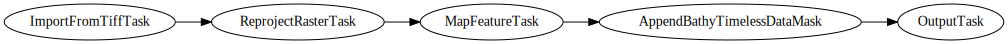

In [10]:
output_label = 'millie_lacs_eop'
nodes = linearly_connect_tasks(
    import_millie_lacs,
    reproject_bathy,
    recalculate_to_meters,
    append_bathy_data_mask,
    OutputTask(output_label)
)
workflow = EOWorkflow(nodes)

workflow.dependency_graph()

At this point no computation has happened. After executing the workflow we can retrieve the EOPatch from the workflow result. The output tells us that this particular EOPatch holds timeless data (data which is assumed to stay constant over time unlike e.g. information in satellite observations that are assumed to be different with every overpass) and a timeless mask with the dimensions `height x width x channels`. For a bathymetry map holding only depth values there is only a single channel. An EOPatch also usually holds information about the data's bounding box.

In [11]:
worfklow_result = workflow.execute()
millie_lacs_eop = worfklow_result.outputs[output_label]

millie_lacs_eop

EOPatch(
  data_timeless={
    bathy_data: numpy.ndarray(shape=(2871, 2794, 1), dtype=float32)
  }
  mask_timeless={
    bathy_data_mask: numpy.ndarray(shape=(2871, 2794, 1), dtype=uint8)
  }
  bbox=BBox(((436481.2917158468, 5106398.21482021), (464421.2917158468, 5135108.21482021)), crs=CRS('32615'))
)

To check if the data looks as expected we can plot a bathymetry heatmap.

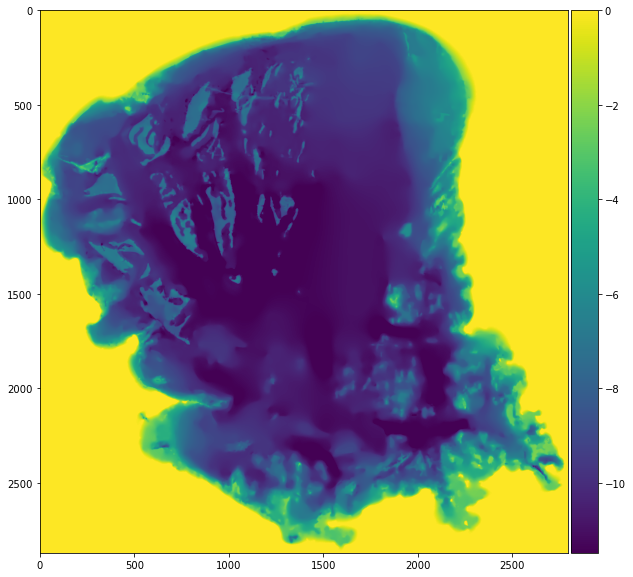

In [12]:
eolx.visualization.plot_single_band(millie_lacs_eop, bathy_feature, cmap='viridis')
plt.show()

If we look at the distribution of depth values for the AOI we see that all values are below 13 meters of depth. From the perspective of the sun's ability to penetrate water and - in theory - reach the bottom of the lake this depth profile appears to be good target for satellite derived bathymetry given that I plan to use the Stumpf Log-Regression method as a baseline model which should work reasonably well for clear waters with depths ranging to roughly 15 meters (Stumpf et al, 2003). The only caveat would be that the waters of most lakes are usually less clear than shallow coastal areas in the Bahamas or in Puerto Rico. We can assume that general turbidity and aquatic plant growth will have a noticeable effect on the estimation quality in this project.

In the histogram below we can also see that there is a relatively large amount of pixels with values bordering at zero meters in depth. I assume that this is the case because the bathymetry map also includes the shoreline. The Puerto Rico and Bahamas AOIs were selected in a way that makes sure that likelihood of inspecting pixels that are not actually covered by water is very limited. As we are looking at the complete extent of the lake it is not unlikely that some parts of the shoreline will not be covered by water in Sentinel-2 observations depending on the acquisition time. It is possible to alleviate this by algorithmically detecting the shoreline in the Sentinel-2 imagery and creating data masks based on the shoreline detection results. This would exceed the scope of this project, though, so I rather opted for the less sophisticated method of applying a negative buffer of 30 meters to the shoreline to create a new bathymetry data mask.

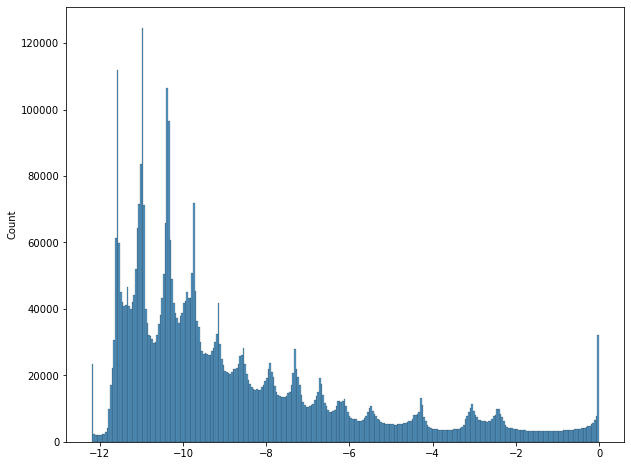

In [13]:
plt.figure(figsize=(10, 8))
sns.histplot(millie_lacs_eop[bathy_feature][millie_lacs_eop[bathy_feature] < 0].flatten())
plt.show()

I prepared the geometry of the buffered shore outline in QGIS by vectorizing the outline of the bathymetry map (or rather all the pixels that were not zero) and then subtracting a negative buffer of 30 meters. The eo-learn framework offers a standard task to import the shapefile as a vector feature (in this case one without a time dimension).

In [14]:
bathy_shape_path = os.path.abspath(
    os.path.join(data_root_path, 'shapes', 'vectorized_outline_mille_lacs_minus_30m_buffer.shp')
)

shoreline_buffer_feature = (FeatureType.VECTOR_TIMELESS, 'bathy_shape_minus_30m_buffer')
read_bathy_shape = VectorImportTask(
    shoreline_buffer_feature,
    path=bathy_shape_path
)

We want to to use the extent of this shape as a new mask to indicate valid bathymetry data points. I achieved this by using eo-learn's standard `VectorToRaster` task. As we want to conform with the 10 by 10 meter resolution of the Sentinel-2 bands with the finest spatial resolution we configure the task to return the mask in the same resolution.

In [15]:
vector_to_raster = VectorToRasterTask(
    shoreline_buffer_feature,
    (FeatureType.MASK_TIMELESS, 'buffered_bathy_mask'),
    raster_resolution=(10, 10),
    raster_dtype=np.uint8,
    values=1,
    no_data_value=0
)

We could store the shape of the buffered outline as part of the EOPatch but because I don't have any other use for it other than creating the mask as well as the fact that in my exact system configuration this would cause an error anyway I decided to remove the feature again.

In [16]:
remove_vector_feature = RemoveFeatureTask(features=shoreline_buffer_feature)

We already have an existing EOPatch which we want to be processed. I use the standard eo-learn `InputTask` to supply it to the pipeline, save the processing output to disk and return the resulting EOPatch for further inspection in Python. We can see the resulting linear workflow dependency graph below.

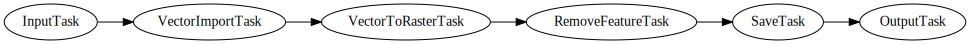

In [17]:
provide_workflow_input = InputTask(millie_lacs_eop)

output_path = os.path.abspath(
    os.path.join(data_root_path, 'eopatches', 'mille_lacs_bathy_eop')
)

save_eop = SaveTask(
    output_path,
    overwrite_permission=OverwritePermission.OVERWRITE_PATCH
)

output_label = 'millie_lacs_eop_buffered'
nodes = linearly_connect_tasks(
    provide_workflow_input,
    read_bathy_shape,
    vector_to_raster,
    remove_vector_feature,
    save_eop,
    OutputTask(output_label)
)
workflow = EOWorkflow(nodes)

workflow.dependency_graph()

As usual with workflows in eo-learn nothing gets computed before we explicitly execute it. After triggering the processing we can see an additional timeless mask feature that holds the buffered bathymetry mask.

In [18]:
worfklow_result = workflow.execute()
millie_lacs_eop = worfklow_result.outputs[output_label]

millie_lacs_eop

EOPatch(
  data_timeless={
    bathy_data: numpy.ndarray(shape=(2871, 2794, 1), dtype=float32)
  }
  mask_timeless={
    bathy_data_mask: numpy.ndarray(shape=(2871, 2794, 1), dtype=uint8)
    buffered_bathy_mask: numpy.ndarray(shape=(2871, 2794, 1), dtype=uint8)
  }
  bbox=BBox(((436481.2917158468, 5106398.21482021), (464421.2917158468, 5135108.21482021)), crs=CRS('32615'))
)

The histogram of the pixel values that are valid regression labels for bathymetry estimations now includes less points close to zero and therefore most likely less pixels that could be not covered by water in certain Sentinel-2 observations. Of course, this precaution could lead to an underestimation of particularly shallow regions near the shore but a more sophisticated data set preparation for this problem domain would best be tackled in additional projects.

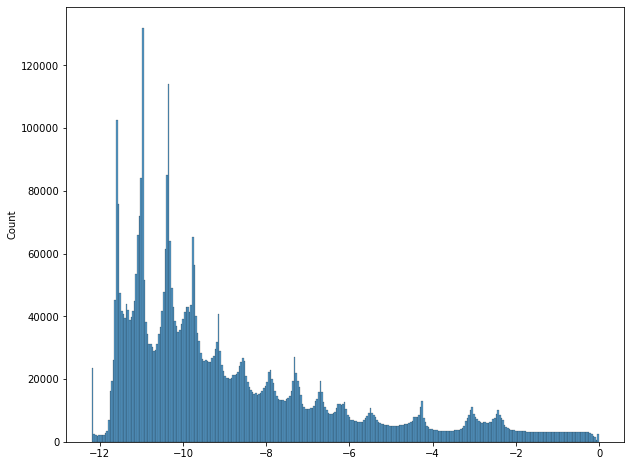

In [19]:
plt.figure(figsize=(10, 8))
sns.histplot(millie_lacs_eop[bathy_feature][millie_lacs_eop[(FeatureType.MASK_TIMELESS, 'buffered_bathy_mask')] == 1].flatten())
plt.show()